## Simulation : Predicting AQI

In [8]:
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from branca.colormap import linear
from shapely.geometry.polygon import Polygon
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from matplotlib import pyplot as plt

from sklearn.utils import resample
import pickle

Build functions for simulation

In [2]:
# Input air type, empty df with columns of pickle, year, month and num of power plants within certain miles
# Return dataset for simulation
def make_dataset(df_test, data_50, data_100, data_150, i_year=2020, i_month=3, num_0_50=0, num_50_100=0, num_100_150=0):
    
    # Resample
    df_test = pd.concat([df_test, resample(data_50, n_samples=num_0_50, replace=True)], axis=0, sort=False)
    df_test = pd.concat([df_test, resample(data_100, n_samples=num_50_100, replace=True)], axis=0, sort=False)
    df_test = pd.concat([df_test, resample(data_150, n_samples=num_100_150, replace=True)], axis=0, sort=False)
            
    df_test['year'] = i_year
        
    # Take care of dummied months
    for i in range(2, 13, 1):
        if i == i_month:
            df_test['month_'+str(i)] = 1
        else:
            df_test['month_'+str(i)] = 0
    
    return df_test

In [3]:
# Functino to simulate with a picked model
def get_pred(model_path, sample):
    
    with open(model_path, 'rb') as f:
        mdl = pickle.load(f)
    
    return mdl.predict(sample).mean()

#### Random Forest Simulation

In [5]:
columns = pd.read_csv('../data/simul/rf_oz_Arizona_allpp_columns.csv')
smpl = make_dataset(columns,
                    pd.read_csv('../data/simul/rf_oz_Arizona_allpp_50.csv'),
                    pd.read_csv('../data/simul/rf_oz_Arizona_allpp_100.csv'),
                    pd.read_csv('../data/simul/rf_oz_Arizona_allpp_150.csv'),
                    2020, 7, 50, 150, 400)

In [28]:
get_pred('./pickles/rf_oz_Arizona_allpp.pickle', smpl)

55.20341431631856

In [29]:
columns = pd.read_csv('../data/simul/rf_pm_Indiana_allpp_columns.csv')
smpl = make_dataset(columns,
                    pd.read_csv('../data/simul/rf_pm_Indiana_allpp_50.csv'),
                    pd.read_csv('../data/simul/rf_pm_Indiana_allpp_100.csv'),
                    pd.read_csv('../data/simul/rf_pm_Indiana_allpp_150.csv'),
                    2020, 3, 50, 300, 500)

In [30]:
get_pred('./pickles/rf_pm_Indiana_allpp.pickle', smpl)

28.8318461092449

#### Make a map with simulation data

In [20]:
fuel_color = {'Fossil_fuel':'red', 'Oil':'purple', 'Biomass':'brown', 'Gas':'pink',
              'Hydro': 'yellow', 'Nuclear': 'green', 'Sun':'orange', 'Wind': 'gray'}

In [24]:
shape_load = gpd.read_file('../data/shape_states')

,state,year,automobile,bus,truck,motorcycle,all_mv,k_acres,cancer,pop,mv_per_k_a,cancer_per,all_mv_k,oz_aqi,pm2_5_aqi,geometry
0,Alabama,2017,2065463,5682.0,2872743,112185.0,5056073.0,33432,None,None,151.234536,None,5056.073,36.932773,36.898953,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."


In [39]:
def make_simul_map(shape, shape_column, shape_caption, data, data_cat, data_val, ctr_ll, states, pred):
    color_map = linear.Blues_09.scale(min(shape[shape_column]), max(shape[shape_column]))
    color_map = color_map.to_step(index=np.linspace(shape[shape_column].min(), shape[shape_column].max(), 10, endpoint=True).round(0))

    pred_color = color_map(pred)
    shape = shape[shape['state'].isin(states)]
    
    m = folium.Map([ctr_ll[0], ctr_ll[1]], zoom_start=6)

    style_function = lambda x: {
        'fillColor': pred_color,
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.7
    }

    folium.GeoJson(
        shape,
        style_function=style_function
    ).add_to(m)

    for idx, row in data.iterrows():
        folium.CircleMarker(location=(row['lat'], row['long']),
                            radius= row[data_val]+2,
                            color=fuel_color[row[data_cat]],
                            fill=True,
                            fillColor=fuel_color[row[data_cat]],
                            fill_opacity = 0.4,
                            stroke=False,
                            tooltip=row[data_cat]).add_to(m)
    
    color_map.caption = shape_caption
    color_map.add_to(m)
    return m

In [36]:
columns = pd.read_csv('../data/test/rf_pm_Indiana_allpp_columns.csv')
smpl = make_dataset(columns,
                    pd.read_csv('../data/test/rf_pm_Indiana_allpp_50.csv'),
                    pd.read_csv('../data/test/rf_pm_Indiana_allpp_100.csv'),
                    pd.read_csv('../data/test/rf_pm_Indiana_allpp_150.csv'),
                    2020, 3, 50, 300, 500)
pp_data = smpl[['lat', 'long', 'fuel', 'pp_boiler', 'state']]
smpl.drop(columns=['lat', 'long', 'fuel', 'state'], axis=1, inplace=True)

In [38]:
pred = get_pred('./pickles/rf_pm_Indiana_allpp.pickle', smpl)

28.9381556120784

In [40]:
air = 'oz_aqi'
states_Indiana = ['Indiana', 'Illinois', 'Kentucky', 'Ohio', 'Michigan', 'Wisconsin']
ctr_ll = (39.849426, -86.258278)
map_pp = make_simul_map(shape_load, air, 'Average AQI', pp_data, 'fuel', 'pp_boiler', ctr_ll, states_Indiana, pred)

map_pp.save('../templates/simul_map_' + air + '_' + str(year) + '.html')

In [23]:
shape_load['year'].unique()

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003], dtype=int64)

Prophet Simulation

In [6]:
state = 'Indiana'
air_type = 'pm2_5'
pred_year = 2020
pred_month = 7
pred_value = 30


In [12]:
def save_prophet_plot(state, air_type, pred_year, pred_month, pred_value):
    if pred_month < 10:
        pred_date = pd.to_datetime(str(pred_year)+'-0'+str(pred_month)+'-15')
    else:        
        pred_date = pd.to_datetime(str(pred_year)+'-'+str(pred_month)+'-15')
    
    model = pickle.load(open('./pickles/prophet_'+air_type+'_'+state+'.pickle', 'rb'))
    
    dt_future = model.make_future_dataframe(periods=365)
    model_forecast = model.predict(dt_future)  
    fig = model.plot(model_forecast)
    plt.scatter(pred_date, pred_value, color = 'red', alpha=0.6)
    
    fig.savefig('../static/imgs/simul_prophet_' + air_type + '_' + state + '.png')

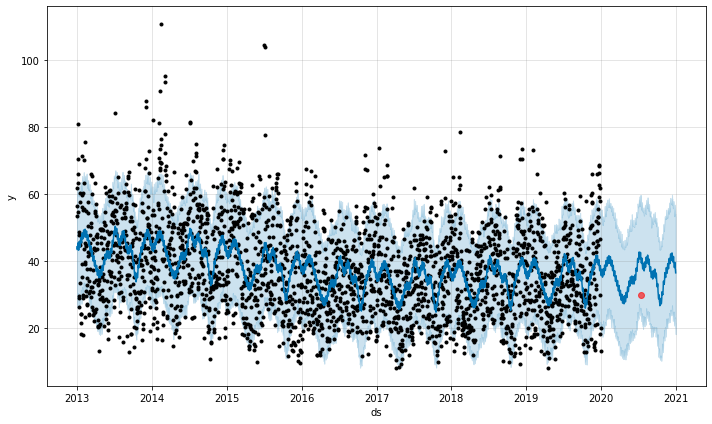

In [13]:
save_prophet_plot(state, air_type, pred_year, pred_month, pred_value)